In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [51]:
import gresearch_crypto
import pandas as pd

In [52]:
env = gresearch_crypto.make_env()

Exception: You can only call `make_env()` once.

timestamp - A timestamp for the minute covered by the row.  
Asset_ID - An ID code for the cryptoasset.  
Count - The number of trades that took place this minute.  
Open - The USD price at the beginning of the minute.  
High - The highest USD price during the minute.  
Low - The lowest USD price during the minute.  
Close - The USD price at the end of the minute.  
Volume - The number of cryptoasset units traded during the minute.  
VWAP - The volume weighted average price for the minute.  
Target - 15 minute residualized returns. See the 'Prediction and Evaluation' section of this notebook for details of how the target is calculated.  

In [ ]:
train_df = pd.read_csv('../input/g-research-crypto-forecasting/train.csv', low_memory=False, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64'
                             }
                      )
train_df.head(3)

In [ ]:
train_df.head(10)

In [ ]:
iter_test = env.iter_test()

In [ ]:
(test_df, sample_prediction_df) = next(iter_test)

In [ ]:
test_df.head(5)

In [ ]:
sample_prediction_df

In [ ]:
next(iter_test)

In [ ]:
env.predict(sample_prediction_df)

# EDA - 1st look to data

In [ ]:
import matplotlib.pyplot as plt

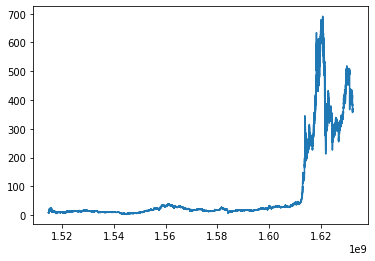

In [53]:
# asset 1
data_list = list()

for i in range(max(train_df.Asset_ID)):
    data_list.append(train_df[train_df.Asset_ID == i].set_index('timestamp'))


plt.plot(data_list[0].index, data_list[0].Open)

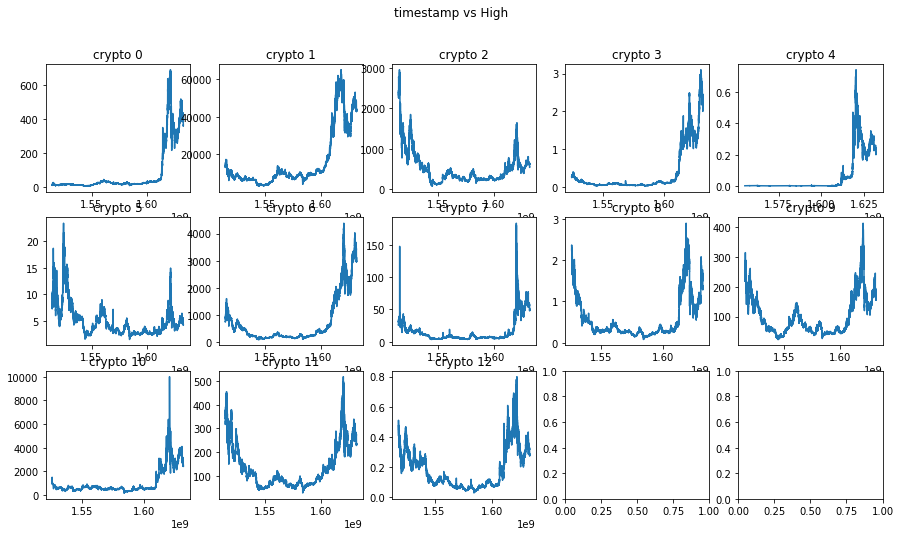

<Figure size 432x288 with 0 Axes>

In [54]:
def plot_crypto(number:int, y:str, x=None, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    
    if x is not None: 
        ax.plot(data_list[number][x], data_list[number][y], **plt_kwargs)
        ax.set_title(f'crypto {number}')
        plt.close()
    else:
        ax.plot(data_list[number].index, data_list[number][y], **plt_kwargs)
        ax.set_title(f'crypto {number}')
        plt.close()
    return ax

def plot_all(y:str, x=None):
    fig, ax = plt.subplots(3,5, figsize=(15,8))
    if x:
        plt.suptitle(f'{x} vs {y}')
    else:
        plt.suptitle(f'timestamp vs {y}')
    row, col = (0,0)
    for i in range(13):
        plot_crypto(i, y, x, ax = ax[row,col])
        if col < 4:
            col += 1
        else:
            row += 1
            col = 0

    plt.tight_layout()
    
    return fig


plot_all('High')

EDA to-do list
1. split time - year / month / day / hour / min
2. calculate other terms in regard of Cryptocurrency - what more?
3. how to connect cryptos each other?
4. How to find and apply Outlier / Seasonality?

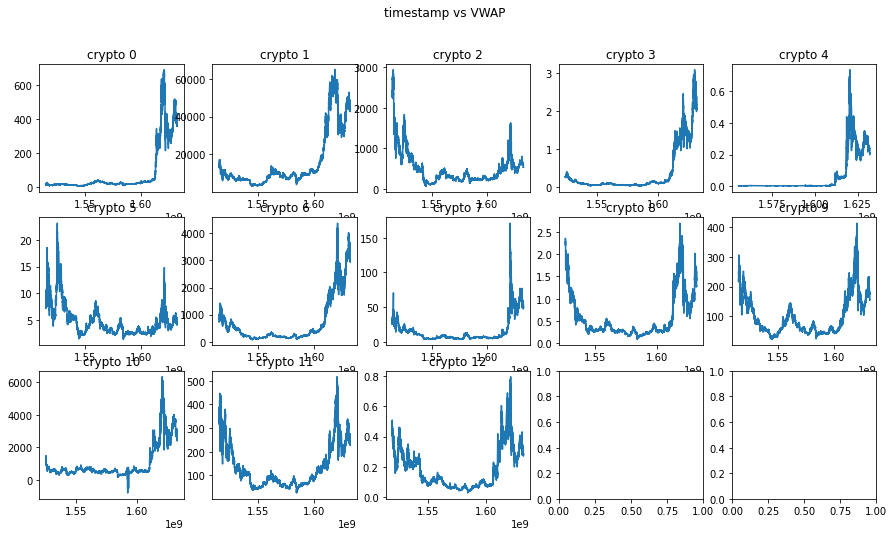

<Figure size 432x288 with 0 Axes>

In [55]:
plot_all("VWAP")

## 1st Model from Tutorial  
ref : https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition

In [ ]:
# 결측치 제거
train_df.shape, len(data_list)

In [ ]:
# 결측치 파악
for i in range(13):
    print(data_list[i].isna().sum())

Notice that there are many gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps. To fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value.

In [56]:
# data gap time 확인
(data_list[6].index[1:]-data_list[6].index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

In [65]:
# fill data gap using reindex
data_list_pad = data_list.copy()

for i, data in enumerate(data_list_pad):
    data = data.reindex(range(data.index[0], data.index[-1]+60, 60),
                       method='pad')
    data_list_pad[i] = data

In [66]:
# check the difference
(data_list_pad[6].index[1:]-data_list_pad[6].index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

In [67]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

## Feature design
We first design a few relevant features to input to our model.

In [69]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low


# 임시로 btc와 eth 만 사용함
btc = data_list_pad[0]
eth = data_list_pad[6]

X_btc = pd.concat([log_return(data_list_pad[0].VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)

y_eth = eth.Target

In [68]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))